import libraries / modules

In [1]:
import pandas as pd
import geopandas as gpd
import lightgbm as lgb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    FunctionTransformer
)

load & prepare data

In [2]:
faults_raw = pd.read_csv("../data/J1939Faults.csv", dtype={"EquipmentID": str, 'spn':int})
diagnostics_raw = pd.read_csv("../data/vehiclediagnosticonboarddata.csv")
display(faults_raw.head())
display(diagnostics_raw.head())

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp
0,1,990349,2015-02-21 10:47:13.000,Low (Severity Low) Engine Coolant Level,NaN,unknown,unknown,unknown,unknown,0,111,17,True,2,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:34:25.000
1,2,990360,2015-02-21 11:34:34.000,NaN,NaN,unknown,unknown,unknown,unknown,11,629,12,True,127,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:35:10.000
2,3,990364,2015-02-21 11:35:31.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,False,127,NaN,1369,105336226,41.421250,-87.767361,2015-02-21 11:35:26.000
3,4,990370,2015-02-21 11:35:33.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,True,127,NaN,1369,105336226,41.421018,-87.767361,2015-02-21 11:36:08.000
4,5,990416,2015-02-21 11:39:41.000,NaN,NaN,22281684P01*22357957P01*22362082P01*,13063430,0USA13_13_0415_2238A,VOLVO,0,4364,17,False,2,NaN,1674,105427130,38.416481,-89.442638,2015-02-21 11:39:37.000


,Id,Name,Value,FaultId
0,1,IgnStatus,False,1
1,2,EngineOilPressure,0,1
2,3,EngineOilTemperature,96.74375,1
3,4,TurboBoostPressure,0,1
4,5,EngineLoad,11,1


In [3]:
# prepare faults
faults_drop_cols = ["actionDescription", "activeTransitionCount", "eventDescription", "ecuSource", "ecuSoftwareVersion", "ecuModel", "ecuMake", "faultValue", "MCTNumber", "LocationTimeStamp"]
faults = faults_raw.drop(columns=faults_drop_cols)
print("\n\n--------FAULTS_RAW COLUMNS--------")
display(faults.columns)
print("\n\n--------SHAPE OF FAULTS--------")
display(faults.shape)
print("\n\n--------NaNs--------")
display(faults.isna().sum())



--------FAULTS_RAW COLUMNS--------


Index(['RecordID', 'ESS_Id', 'EventTimeStamp', 'ecuSerialNumber', 'spn', 'fmi',
       'active', 'EquipmentID', 'Latitude', 'Longitude'],
      dtype='object')



--------SHAPE OF FAULTS--------


(1187335, 10)



--------NaNs--------


RecordID                0
ESS_Id                  0
EventTimeStamp          0
ecuSerialNumber    343017
spn                     0
fmi                     0
active                  0
EquipmentID             0
Latitude                0
Longitude               0
dtype: int64

In [4]:
# join diagnostics
print("--------NaNs--------")
print(diagnostics_raw.isna().sum())
n_ids = len(diagnostics_raw['Id'])
n_unique_id = diagnostics_raw['Id'].nunique()
n_un_faults = diagnostics_raw['FaultId'].nunique()

diagnostics_raw["Value"] = diagnostics_raw["Value"].replace(
    {"FALSE": False, "TRUE": True}
)

# pivot diagnostics to long format
diagnostics = diagnostics_raw.pivot(
    index="FaultId", columns="Name", values="Value"
)

print(f"\nlen(Id): {n_ids}", f"\nN unique_Id: {n_unique_id}")
print("\n--------RECORD ID vs FAULT ID--------")
print(f"n_unique FaultID: {n_un_faults}", f"\nn_unique RecordID: {faults['RecordID'].nunique()}")
joined = faults.merge(diagnostics, how = "inner", left_on='RecordID', right_on='FaultId')
print("\n\n--------JOINED--------")
display(joined.head())
print("\n\n--------JOINED COLUMNS---------")
print(joined.columns)


--------NaNs--------
Id         0
Name       0
Value      0
FaultId    0
dtype: int64

len(Id): 12821626 
N unique_Id: 12821626

--------RECORD ID vs FAULT ID--------
n_unique FaultID: 1187335 
n_unique RecordID: 1187335


--------JOINED--------


,RecordID,ESS_Id,EventTimeStamp,ecuSerialNumber,spn,fmi,active,EquipmentID,Latitude,Longitude,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
0,1,990349,2015-02-21 10:47:13.000,unknown,111,17,True,1439,38.857638,-84.626851,...,NaN,False,78.8,1023,True,NaN,0,3276.75,NaN,0
1,2,990360,2015-02-21 11:34:34.000,unknown,629,12,True,1439,38.857638,-84.626851,...,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
2,3,990364,2015-02-21 11:35:31.000,unknown,1807,2,False,1369,41.421250,-87.767361,...,NaN,NaN,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
3,4,990370,2015-02-21 11:35:33.000,unknown,1807,2,True,1369,41.421018,-87.767361,...,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
4,5,990416,2015-02-21 11:39:41.000,13063430,4364,17,False,1674,38.416481,-89.442638,...,NaN,NaN,NaN,16639,NaN,NaN,NaN,NaN,NaN,NaN




--------JOINED COLUMNS---------
Index(['RecordID', 'ESS_Id', 'EventTimeStamp', 'ecuSerialNumber', 'spn', 'fmi',
       'active', 'EquipmentID', 'Latitude', 'Longitude', 'AcceleratorPedal',
       'BarometricPressure', 'CruiseControlActive', 'CruiseControlSetSpeed',
       'DistanceLtd', 'EngineCoolantTemperature', 'EngineLoad',
       'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm',
       'EngineTimeLtd', 'FuelLevel', 'FuelLtd', 'FuelRate', 'FuelTemperature',
       'IgnStatus', 'IntakeManifoldTemperature', 'LampStatus', 'ParkingBrake',
       'ServiceDistance', 'Speed', 'SwitchedBatteryVoltage', 'Throttle',
       'TurboBoostPressure'],
      dtype='object')


filter out faults near service stations

In [5]:
joined_pre_station_filter = joined

In [6]:
# filter out near service stations
joined_pre_station_filter = joined
print("Labeling faults near service stations...")
stations = pd.DataFrame(
    {
        "lat": [36.0666667, 35.5883333, 36.1950],
        "lon": [-86.4347222, -86.4438888, -83.174722],
    }
)
threshold_miles = 0.5
threshold_meters = threshold_miles * 1609.34
# create geodataframes with geopandas
gdf_joined = gpd.GeoDataFrame(
    joined,
    geometry=gpd.points_from_xy(joined.Latitude, joined.Longitude),
    crs="EPSG:4326",  # WGS84 coord ref sys (lat/lon)
)
gdf_stations = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations.lat, stations.lon),
    crs="EPSG:4326",
)
target_crs = "EPSG:9311"
# reproject onto new crs for better distance measurement
gdf_joined_proj = gdf_joined.to_crs(target_crs)
gdf_stations_proj = gdf_stations.to_crs(target_crs)
# create buffers around stations
station_buf = gdf_stations_proj.geometry.buffer(threshold_meters)
combined_buffer = (
    station_buf.union_all()
)  # turns into single geometry which helps with efficiency
is_within = gdf_joined_proj.geometry.within(combined_buffer)
joined["nearStation"] = is_within.values
joined_post_filter = joined[~joined["nearStation"]]
print("\nDone! \nFaults within 1km of service station labeled in 'joined'.")
print(
    f"When filtered, this removes {len(joined_pre_station_filter['RecordID']) - len(joined_post_filter['RecordID'])} rows"
)
# filter out active=False
joined_active = joined[joined["active"]]
print(
    f"\nNumber of rows after filtering active=False out: {len(joined_active['active'])}"
)
print(
    f"Rows removed: {len(joined_pre_station_filter['RecordID']) - len(joined_active['active'])}"
)



Labeling faults near service stations...

Done! 
Faults within 1km of service station labeled in 'joined'.
When filtered, this removes 129284 rows

Number of rows after filtering active=False out: 608454
Rows removed: 578881


In [7]:
print(joined.columns)

Index(['RecordID', 'ESS_Id', 'EventTimeStamp', 'ecuSerialNumber', 'spn', 'fmi',
       'active', 'EquipmentID', 'Latitude', 'Longitude', 'AcceleratorPedal',
       'BarometricPressure', 'CruiseControlActive', 'CruiseControlSetSpeed',
       'DistanceLtd', 'EngineCoolantTemperature', 'EngineLoad',
       'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm',
       'EngineTimeLtd', 'FuelLevel', 'FuelLtd', 'FuelRate', 'FuelTemperature',
       'IgnStatus', 'IntakeManifoldTemperature', 'LampStatus', 'ParkingBrake',
       'ServiceDistance', 'Speed', 'SwitchedBatteryVoltage', 'Throttle',
       'TurboBoostPressure', 'nearStation'],
      dtype='object')


In [8]:
full_derates_raw = joined[joined['spn'] == 5246]
partial_derates_raw = joined[(joined['spn'] == 1569) & (joined['fmi'] == 31)]
# print("--------FULL DERATES---------")
# display(f"derate shape: {full_derates_raw.shape}", full_derates_raw.head(3))
#print("\n--------PARTIAL DERATES---------")
#display(f"partial derate shape: {partial_derates_raw.shape}", partial_derates_raw.head(3))

- [x] look at time series by Equipment ID

In [9]:
col_order = [
    "RecordID",
    "EquipmentID",
    "EventTimeStamp",
    "spn",
    "fmi",
    "active",
    "Latitude",
    "Longitude",
    "AcceleratorPedal",
    "BarometricPressure",
    "CruiseControlActive",
    "CruiseControlSetSpeed",
    "DistanceLtd",
    "EngineCoolantTemperature",
    "EngineLoad",
    "EngineOilPressure",
    "EngineOilTemperature",
    "EngineRpm",
    "EngineTimeLtd",
    "FuelLevel",
    "FuelLtd",
    "FuelRate",
    "FuelTemperature",
    "IgnStatus",
    "IntakeManifoldTemperature",
    "LampStatus",
    "ParkingBrake",
    "ServiceDistance",
    "Speed",
    "SwitchedBatteryVoltage",
    "Throttle",
    "TurboBoostPressure",
    "nearStation",
    "ESS_Id",
    "ecuSerialNumber",
]
target_spn = 5246

# Ensure EventTimeStamp is datetime
joined["EventTimeStamp"] = pd.to_datetime(joined["EventTimeStamp"])

# --- SORTING STEP ---
# Sort by EquipmentID and then chronologically by EventTimeStamp
print("Sorting data by EquipmentID and EventTimeStamp...")
joined = joined.sort_values(by=["EquipmentID", "EventTimeStamp"]).copy()
print("Sorting complete.")

# Create a Series containing only the timestamps of trigger events
trigger_timestamps_only = joined["EventTimeStamp"].where(joined["spn"] == target_spn)

# For each row, find the timestamp of the *next* trigger event within its group
# Group by EquipmentID and use backward fill (bfill)
# This fills NaT values with the next valid timestamp in the group
print("Calculating next trigger time...")
joined["next_trigger_time"] = trigger_timestamps_only.groupby(
    joined["EquipmentID"]
).bfill()

# Calculate the start of the 2-hour window before the next trigger
joined["window_start_time"] = joined["next_trigger_time"] - pd.Timedelta(hours=2.5)

# Label rows as True if their timestamp falls within the window:
#    [wind`ow_start_time, next_trigger_time]
#    Also ensure that a next_trigger_time actually exists (it's not NaT)
print("Labeling derate window...")
joined["derate_window"] = (
    (joined["EventTimeStamp"] >= joined["window_start_time"])
    & (joined["EventTimeStamp"] <= joined["next_trigger_time"])
    & (joined["next_trigger_time"].notna())
)

# Optional: Reorder columns if desired (ensure 'derate_window' is in col_order)
# joined = joined[col_order]

# --- Verification ---
print("\nVerification:")
print(
    "Value counts for 'derate_window':\n",
    joined["derate_window"].value_counts(),
)
print(
    "\nValue counts for 'spn' (to confirm target SPN exists):\n",
    joined["spn"].value_counts(),
)

# Display some rows where derate_window is True (if any)
print("\nSample rows where derate_window is True:")
print(
    joined[joined["derate_window"]][
        ["EquipmentID", "EventTimeStamp", "spn", "next_trigger_time"]
    ].head()
)

# Display some rows around a trigger event for a specific EquipmentID
# Find an EquipmentID that has a trigger event
example_eqid = joined.loc[joined["spn"] == target_spn, "EquipmentID"].iloc[0]
print(f"\nSample data around trigger for EquipmentID: {example_eqid}")
example_trigger_time = joined.loc[
    (joined["EquipmentID"] == example_eqid) & (joined["spn"] == target_spn),
    "EventTimeStamp",
].min()
# Filter data around that time for that equipment
print(
    joined[
        (joined["EquipmentID"] == example_eqid)
        & (joined["EventTimeStamp"] >= (example_trigger_time - pd.Timedelta(hours=3)))
        & (joined["EventTimeStamp"] <= (example_trigger_time + pd.Timedelta(hours=1)))
    ][
        [
            "EquipmentID",
            "EventTimeStamp",
            "spn",
            "next_trigger_time",
            "window_start_time",
            "derate_window",
        ]
    ]
)

# Optional: Drop helper columns if no longer needed
# joined = joined.drop(columns=['next_trigger_time', 'window_start_time'])


Sorting data by EquipmentID and EventTimeStamp...
Sorting complete.
Calculating next trigger time...
Labeling derate window...

Verification:
Value counts for 'derate_window':
 derate_window
False    1183869
True        3466
Name: count, dtype: int64

Value counts for 'spn' (to confirm target SPN exists):
 spn
111      365489
929      256541
96        90041
829       87788
639       41062
          ...  
54478         1
65287         1
37265         1
56503         1
46262         1
Name: count, Length: 450, dtype: int64

Sample rows where derate_window is True:
       EquipmentID      EventTimeStamp   spn   next_trigger_time
996835   105349576 2018-07-06 09:42:48  5246 2018-07-06 09:42:48
998108   105349576 2018-07-10 15:43:25  3364 2018-07-10 15:43:58
998109   105349576 2018-07-10 15:43:25  1761 2018-07-10 15:43:58
998110   105349576 2018-07-10 15:43:25  1761 2018-07-10 15:43:58
998111   105349576 2018-07-10 15:43:25   111 2018-07-10 15:43:58

Sample data around trigger for Equipment

In [10]:
temp_df = joined[['RecordID', 'EquipmentID', 'spn', 'fmi', 'EventTimeStamp', 'derate_window']]
display(temp_df[temp_df['spn']==5246].head(5))

,RecordID,EquipmentID,spn,fmi,EventTimeStamp,derate_window
996835,1032993,105349576,5246,0,2018-07-06 09:42:48,True
998112,1034270,105349576,5246,0,2018-07-10 15:43:58,True
156410,158796,105360462,5246,0,2015-08-10 10:26:40,True
185581,187967,105411041,5246,0,2015-08-31 13:50:42,True
972882,1004301,105427203,5246,0,2018-04-27 06:07:55,True


In [11]:
# some feature engineering:
joined['time_since_last_fault'] = joined.groupby('EquipmentID')['EventTimeStamp'].diff()
joined['fault_frequency'] = joined.groupby('EquipmentID')['spn'].transform('count')

In [12]:
joined[['time_since_last_fault', 'fault_frequency']].dtypes

time_since_last_fault    timedelta64[ns]
fault_frequency                    int64
dtype: object

In [13]:
time_cols = joined.select_dtypes(include=['datetime64', 'timedelta64[ns]'])
time_cols = list(time_cols.columns)
print(time_cols)

['EventTimeStamp', 'next_trigger_time', 'window_start_time', 'time_since_last_fault']


In [14]:
# identify predictors and target
predictors = [
    col
    for col in joined.columns
    if col not in ["RecordID", "spn", "derate_window", time_cols]
]
target = 'derate_window'

X = joined[predictors]
y = joined[target]

# split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

derate_window
False    1183869
True        3466
Name: count, dtype: int64


<Axes: ylabel='count'>

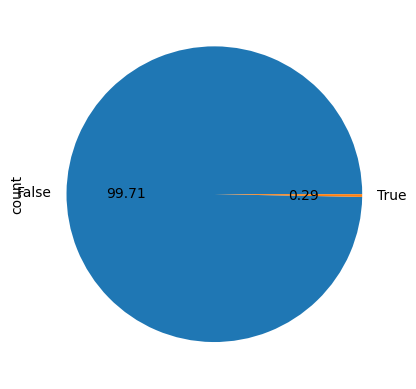

In [15]:
# check for imbalanced data
print(y.value_counts())
y.value_counts().plot.pie(autopct="%.2f")

In [16]:
# identify cols in df w/ datatype numeric
# numeric_selector = make_column_selector(dtype_include="number")
numeric_cols = make_column_selector(dtype_include=np.number)(X_train)
# id cols in df w// dtype object (categorical vars)
categorical_selector = make_column_selector(dtype_include="object")
# handle datetime cols 
timedelta_col = ['time_since_last_fault']
# Remove the timedelta column from the standard numerical list
numeric_cols = [col for col in numeric_cols if col not in timedelta_col]
# preprocess numeric cols
numeric_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)
# preprocess categorical cols
categorical_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "ohe",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
        ),
    ]
)
# Convert timedelta to numerical (total seconds), then impute and scale
timedelta_transformer = Pipeline(steps=[
    # Convert timedelta to total seconds (float). Handle potential NaNs with .values for numpy compatibility.
    # If the result might contain NaNs, the imputer handles them next.
    # check_inverse=False because there's no inverse operation.
    ('convert_to_seconds', FunctionTransformer(lambda x: x.astype('timedelta64[ns]').dt.total_seconds().values.reshape(-1, 1),
                                               validate=False, check_inverse=False)),
    ('imputer', SimpleImputer(strategy='mean')), # Impute NaNs AFTER converting to float
    ('scaler', StandardScaler())
])
# apply numeric and categorical transformers
# Set remainder='passthrough' initially to catch unexpected columns
ct = ColumnTransformer(
    [
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_selector),
        ("delta", timedelta_transformer, timedelta_col)
    ],
    remainder="passthrough",  # Check if any columns are leftover
    verbose_feature_names_out=False,  # Keep feature names cleaner
)

# imbalanced dataset pipeline
pipe = ImbPipeline([
    ("ct", ct),
    ("smote", SMOTE(
        random_state=42,
        k_neighbors=5,
        sampling_strategy=0.1  
    )),
    ("model", lgb.LGBMClassifier(
        force_col_wise=True,
        importance_type="gain",
        random_state=42,
        class_weight="balanced",
        n_estimators=500, 
        learning_rate=0.01
    ))
])
# Set output to df to preserve names through ColumnTransformer
pipe.set_output(transform="pandas")

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['RecordID', 'ESS_Id', 'fmi',
                                                   'Latitude', 'Longitude',
                                                   'fault_frequency']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 s...
                                                                                       func=<function <lambda> at 0x3ad6149a0>)),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['time_since_last_fault'])],
                                   verbose_feature_names_out=False)),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.1)),
                ('model',
                 LGBMClassifier(class_weight='balanced', force_col_wise=True,
                                importance_type='gain', learning_rate=0.01,
                                n_estimators=500, random_state=42))])

In [ ]:
# Hyperparameter tuning
params = {
    "model__n_estimators": [300, 500],
    "model__learning_rate": [0.005, 0.01, 0.025, 0.05],
    "model__num_leaves": [31, 63],
    "model__max_depth": [5, 10, 15],
    "model__reg_alpha": [0, 0.01, 0.1, 1],
    "model__reg_lambda": [0, 0.01, 0.1, 1],
    "model__min_child_samples": [20, 50],
    "smote__k_neighbors": [3, 5, 7]  # Add SMOTE parameters to search
}
cv_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=params,
    n_iter=10,
    cv=cv_strat,
    scoring="f1_macro",
    random_state=42,
    n_jobs=-1,
    verbose=2,
    error_score='raise'
)
print("\nStarting Randomized Search CV...\n")
# Fit the Randomized Search object to the training data
# cross-validated hyperparameter search
random_search.fit(X_train, y_train)
print("\nRandomized Search CV finished.")
# --- Get the Best Model ---
print(
    f"\nBest Macro F1 score found during search: {random_search.best_score_:.4f}"
)
print("Best parameters found:")
# Pretty print best parameters
best_params = random_search.best_params_
for param, value in best_params.items():
    print(f"  {param}: {value}")
# The best estimator found by the search (already refitted on the full X_train_res, y_train_res)
best_pipe = random_search.best_estimator_
# Evaluate the *BEST* model found by the search
print("\n--- Best Model Evaluation on Test Set ---")
# Make predictions using the best pipeline
y_pred_eval = best_pipe.predict(X_test)  # <<--- Use best_pipe here
# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_eval)
print(f"Accuracy: {accuracy:.4f}")
# Print Classification Report (focus on Macro Avg F1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_eval))
macro_f1_test = f1_score(y_test, y_pred_eval, average="macro")
print(f"Best pipe Macro F1 on Test Set: {macro_f1_test:.4f}")
# confusion matrix
print("\nConfusion Matrix:")
try:
    cm = confusion_matrix(y_test, y_pred_eval, labels=best_pipe.classes_)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=best_pipe.classes_
    )
    disp.plot(cmap="Blues")
    plt.xticks(rotation=45, ha="right")  # Improve label readability
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not plot confusion matrix: {e}")

# Feature Importances
print("\n--- Feature Importances (from Best Pipeline) ---")
try:
    # Access the fitted model step from the *best* pipeline
    lgbm_model = best_pipe.named_steps["model"]  # <<--- Use best_pipe here
    # Access the fitted ColumnTransformer step from the *best* pipeline
    col_transformer = best_pipe.named_steps["ct"]  # <<--- Use best_pipe here

    feature_names_out = col_transformer.get_feature_names_out()

    if hasattr(lgbm_model, "feature_importances_"):
        importances = lgbm_model.feature_importances_
        if len(feature_names_out) == len(importances):
            feature_imp_df = pd.DataFrame(
                {"Feature": feature_names_out, "Importance": importances}
            )
            feature_imp_df = feature_imp_df.sort_values(
                by="Importance", ascending=False
            )
            print(feature_imp_df.head(20))  # Print top 20 features
        else:
            print(
                f"Warning: Mismatch in feature name count ({len(feature_names_out)}) and importance count ({len(importances)})."
            )
            print("Feature names from CT:", feature_names_out)
    else:
        print("LGBM model does not have feature_importances_ attribute.")

except Exception as e:
    print(f"Could not retrieve feature importances: {e}")
    
    


In [ ]:
# visualizations
cv_scores = cross_val_score(
    best_pipe,
    X_train,
    y_train,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1 score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# better confusion matrix visualization
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['No Derate', 'Derate']
)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


# feature importance visualization
plt.figure(figsize=(12, 8))
sns.barplot(
    data=feature_imp_df.head(20),
    x='Importance',
    y='Feature',
    palette='viridis'
)
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()